In [1]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd

from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径

import sys
sys.path.append(r"C:\Users\haokw\Documents\GitHub\gaolu\MPC\高炉")
import base 


In [2]:
# 读取Excel文件
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据处理\\新输入输出模式\\1h_mean.xlsx'
df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='原始输出') 
# df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='原始输出 (2)') 
# df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='剔除直线输出') 
# df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='单SI_0.2_0.8') 
# print(df_sheet_yuansu.info())
# print(df_sheet_yuansu.columns)

excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据处理\\新输入输出模式\\1h_mean.xlsx'
df_sheet_params = pd.read_excel(excel_path, sheet_name='1h_mean') 

# print(df_sheet_params.info())
# print(df_sheet_params.columns)



In [3]:
# 定义输入输出参数   '富氧流量', '冷风流量', '热风压力', '冷风温度', '热风温度', '鼓风湿度', '设定喷煤量'
input_term = ['富氧流量', '冷风流量', '热风压力', '冷风温度', '热风温度', '鼓风湿度', '设定喷煤量']
output_term = ['铁口1温度', 'SI']
time_term= '时间戳h'


In [4]:
# 异常数据处理-处理前后对比
# 创建数据框副本以避免修改原始数据
df_sheet_yuansu_process = df_sheet_yuansu.copy()
df_sheet_params_process = df_sheet_params.copy()
# 定义一个函数，用前后两个值的差值按照距离进行加权替换异常值
def replace_outliers_with_weighted_diff(x, y):
    # 计算列的中位数
    median_value = y.median()
    # 检测异常值的索引
    outliers_index = (y - median_value).abs() > 1.5 * y.std()  # 使用标准差作为阈值
    
    # 遍历异常值的索引
    for idx in outliers_index[outliers_index].index:
        # 获取异常值前一个和后一个值的索引
        prev_idx = idx - 1 if idx - 1 >= 0 else idx
        next_idx = idx + 1 if idx + 1 < len(y) else idx
        # 计算当前 x 与前后两个 x 的距离
        dist_prev = abs(x[idx] - x[prev_idx])
        dist_next = abs(x[next_idx] - x[idx])
        total_dist = dist_prev + dist_next
        # 计算权重
        weight_prev = dist_next / total_dist
        weight_next = dist_prev / total_dist
        # 计算前后两个值的差值
        diff = y[next_idx] - y[prev_idx]
        # 根据权重进行插值
        interpolated_value = y[prev_idx] + weight_prev * diff
        # 用插值结果替代异常值
        y[idx] = interpolated_value


# 画出数据
def plot_subplot(data_x,data_y_yuan,data_y,column):
    plt.plot(data_x,data_y_yuan,'r-')
    plt.plot(data_x,data_y,'m-')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签


# 对指定列应用替代异常值的函数
# 对指定列应用替代异常值的函数
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[0]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[1]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[2]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[3]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[4]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[5]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[6]])

replace_outliers_with_weighted_diff(df_sheet_yuansu_process[time_term], df_sheet_yuansu_process[output_term[0]])
replace_outliers_with_weighted_diff(df_sheet_yuansu_process[time_term], df_sheet_yuansu_process[output_term[1]])

# plt.figure(figsize=(15, 10))
# for idx, column in enumerate(input_term):
#     plt.subplot(len(input_term), 1, idx+1)
#     plot_subplot(df_sheet_params_process[time_term].values,df_sheet_params[column].values,df_sheet_params_process[column].values,column)

# plt.figure(figsize=(15, 10))
# for idx, column in enumerate(output_term):
#     plt.subplot(len(output_term), 1, idx+1)
#     plot_subplot(df_sheet_yuansu_process[time_term].values,df_sheet_yuansu[column].values,df_sheet_yuansu_process[column].values,column)




C:\Users\haokw\AppData\Local\Temp\ipykernel_20268\3434438859.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haokw\AppData\Local\Temp\ipykernel_20268\3434438859.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haokw\AppData\Local\Temp\ipykernel_20268\3434438859.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haok

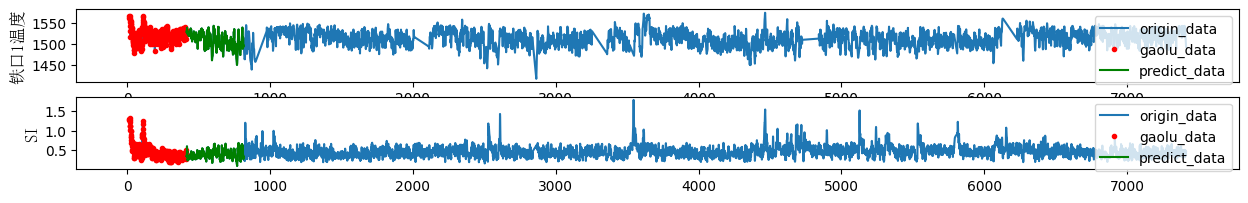

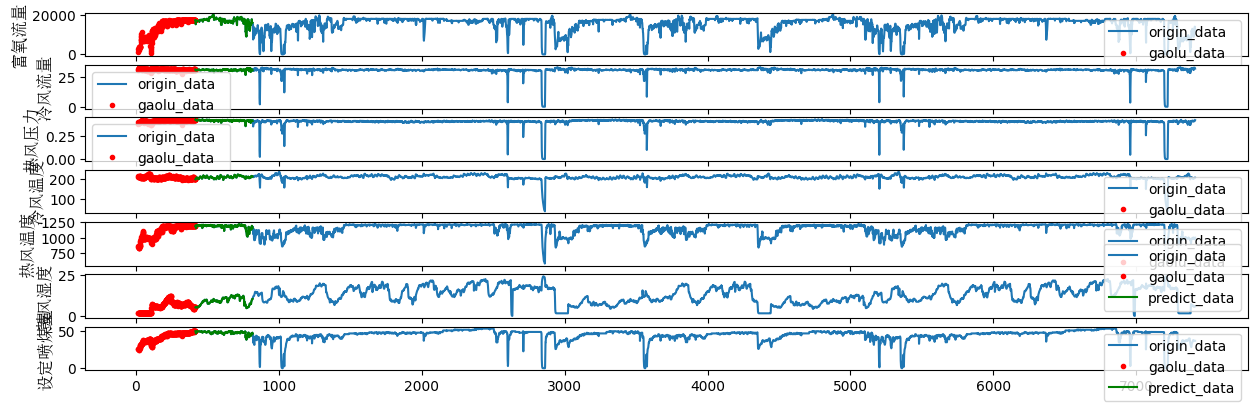

In [5]:
# 画出选取的数据
def plot_subplot(data_x,data_y,column,index_predict,index_gaolu):
    plt.plot(data_x,data_y,'-', label='origin_data')
    plt.plot(data_x[index_gaolu],data_y[index_gaolu],'r.', label='gaolu_data')
    plt.plot(data_x[index_predict],data_y[index_predict],'g-', label='predict_data')
    plt.legend()
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签



length1 = 400
start1 = 0
length2 = 400
start2 = 400


index_gaolu   = range(start1, start1+length1+1, 1)
index_predict     = range(start2, start2+length2+1, 1)
# index = range(1, 7572, 1)


plt.figure(figsize=(15, 10))
for idx, column in enumerate(output_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_yuansu_process[time_term].values,df_sheet_yuansu_process[column].values,column,index_predict,index_gaolu)

plt.figure(figsize=(15, 6))
for idx, column in enumerate(input_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_params_process[time_term].values,df_sheet_params_process[column].values,column,index_predict,index_gaolu)


In [6]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    input_term[0]:   df_sheet_params_process[input_term[0]].values,
    input_term[1]:   df_sheet_params_process[input_term[1]].values,
    input_term[2]:   df_sheet_params_process[input_term[2]].values,
    input_term[3]:   df_sheet_params_process[input_term[3]].values,
    input_term[4]:   df_sheet_params_process[input_term[4]].values,
    input_term[5]:   df_sheet_params_process[input_term[5]].values,
    input_term[6]:   df_sheet_params_process[input_term[6]].values,
    output_term[0]:  df_sheet_yuansu_process[output_term[0]].values,
    output_term[1]:  df_sheet_yuansu_process[output_term[1]].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


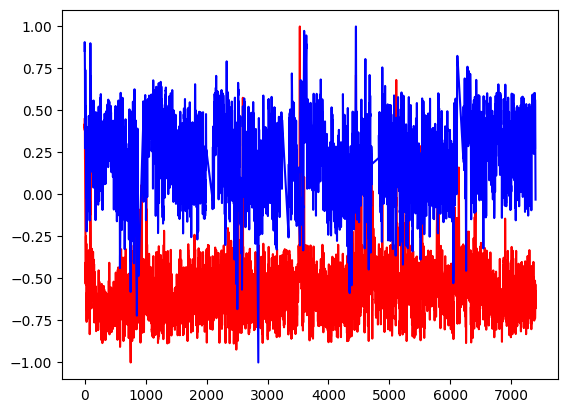

In [7]:
plt.plot(normalized_data_dict['SI'],'r')
plt.plot(normalized_data_dict['铁口1温度'],'b')


In [8]:
# 标定归一化前后数据
data_point = np.array([1500]).reshape(-1, 1)
data1 = scalers[output_term[0]].transform(data_point).flatten()

data_point = np.array(data1).reshape(-1, 1)
data2 = scalers[output_term[0]].inverse_transform(data_point).flatten()

data_point = np.array([1510]).reshape(-1, 1)
data3 = scalers[output_term[0]].transform(data_point).flatten()

data_point = np.array(data3).reshape(-1, 1)
data4 = scalers[output_term[0]].inverse_transform(data_point).flatten()

print(data1)
print(data2)
print(data3)
print(data4)
d_temp = (data3-data1)/(data4-data2)
print('每摄氏度的输出差：',d_temp)



data_point = np.array([0.50]).reshape(-1, 1)
data1 = scalers[output_term[1]].transform(data_point).flatten()

data_point = np.array(data1).reshape(-1, 1)
data2 = scalers[output_term[1]].inverse_transform(data_point).flatten()

data_point = np.array([0.60]).reshape(-1, 1)
data3 = scalers[output_term[1]].transform(data_point).flatten()

data_point = np.array(data3).reshape(-1, 1)
data4 = scalers[output_term[1]].inverse_transform(data_point).flatten()

print(data1)
print(data2)
print(data3)
print(data4)
d_yuansu = (data3-data1)/(data4-data2)
print('每0.01浓度的输出差：',(data3-data1))


[0.05471948]
[1500.]
[0.18042565]
[1510.]
每摄氏度的输出差： [0.01257062]
[-0.52854026]
[0.5]
[-0.40998065]
[0.6]
每0.01浓度的输出差： [0.11855962]


In [44]:
isShuffle = True
isShuffle = False
time_steps = 2


test_size = 0.30
val_size = 0.001
train_size = 1-val_size-test_size


In [45]:
# 组合训练数据--拆分训练、测试集
# 构成    
# X = [X(t),X(t-1),Y(t-1)]
# Y = [Y(t)]
def make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,y1_data,y2_data,index_fanwei):
    X = np.column_stack((u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data))
    y = np.column_stack((y1_data, y2_data))

    X_modified = []
    y_modified = []
    
    for i in range(11,len(y1_data)):
        if i in index_fanwei:
            # print(i)
            # print(df_sheet_yuansu[time_term][i])
            yuansu_time = df_sheet_yuansu[time_term][i]
            closest_10 = df_sheet_params[df_sheet_params[time_term] <= yuansu_time].nlargest(time_steps, time_term)
            # print(closest_10)
            
            index = closest_10.index
            # print(index)
            # print(closest_10.iloc[-1][time_term])
            if closest_10.iloc[-1][time_term] < yuansu_time - time_steps + 1:
                print(i,yuansu_time,'errloss')
            else:

                # print(X[index, :])
                new_x_sample = np.concatenate([X[i, :] for i in index],axis=0)
                # print(new_x_sample)
                # print(y_last, 'y_last time : ',df_sheet_yuansu[time_term][i-1])

                y_last = y[i-1, :]
                new_x_sample = np.concatenate([new_x_sample,y_last],axis=0)

                
                # print(new_x_sample)
                y_sample = y[i, :]  
                X_modified.append(new_x_sample)
                y_modified.append(y_sample)
                print(i,yuansu_time,index[0],index[-1], end='\r')
                # break

    # 将列表转换为 NumPy 数组
    X_modified = np.array(X_modified)
    y_modified = np.array(y_modified)
    X_reshaped = X_modified.reshape((X_modified.shape[0], X_modified.shape[1]))

    # 打印新数据的形状
    print("Modified Input Shape:", X_reshaped.shape)
    print("Modified Output Shape:", y_modified.shape)


    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_modified, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    # 将剩余的70%训练数据再次拆分成训练数据和验证数据（20%验证数据，50%训练数据）
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                        test_size=val_size/(train_size+val_size), 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    print('训练数量：',X_train.shape,y_train.shape)
    print('验证数量：',X_val.shape,y_val.shape)
    print('测试数量：',X_test.shape,y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [46]:
def moving_average_filter(data, N):
    """
    这个函数实现了简单的移动平均滤波。
    
    :param data: 输入的数据序列，一般为列表或者NumPy数组。
    :param N: 滑动窗口的大小。
    :return: 经过滤波处理的数据序列。
    """
    filtered_values = []
    window = []
    for i in range(N):
        window.append(0)
    for i in range(len(data)):
        # 将当前数据点加入到窗口
        window.append(data[i])
        # 如果窗口的大小超过了N，就移除最旧的数据点
        if len(window) > N:
            window.pop(0)
        # 计算窗口内的平均值，并加入到结果中
        filtered_values.append(sum(window) / len(window))
    return np.array(filtered_values)

# 使用例子
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
N = 3
filtered_data = moving_average_filter(data, N)
print(filtered_data)

def symmetrical_moving_average(data, N):
    """
    使用对称的移动平均滤波，当前值由其自身及其前后的值决定。
    
    :param data: 输入的数据序列，一般为列表或者NumPy数组。
    :return: 经过滤波处理的数据序列。
    """
    filtered_data = []
    percent = 0.8
    # 遍历数据，从索引1开始到倒数第二个元素结束
    for i in range(1, len(data) - 1):
        # 计算当前值及其前后值的平均
        average = (data[i - 1]*(1-percent)/2 + data[i]*percent + data[i + 1]*(1-percent)/2)
        filtered_data.append(average)
    
    # 对于序列的第一个和最后一个元素，直接使用原始值
    # 或者可以使用其他边界处理策略
    filtered_data.insert(0, data[0])
    filtered_data.append(data[-1])
    
    return np.array(filtered_data)

# 示例数据
data = [2, 4, 6, 8, 10, 12, 14]
filtered_data = symmetrical_moving_average(data,9)
print(filtered_data)



[0.33333333 1.         2.         3.         4.         5.
 6.         7.         8.         9.        ]
[ 2.  4.  6.  8. 10. 12. 14.]


In [92]:
# 高炉模型列数据
u1_data = normalized_data_dict[input_term[0]]
u2_data = normalized_data_dict[input_term[1]]
u3_data = normalized_data_dict[input_term[2]]
u4_data = normalized_data_dict[input_term[3]]
u5_data = normalized_data_dict[input_term[4]]
u6_data = normalized_data_dict[input_term[5]]
u7_data = normalized_data_dict[input_term[6]]
y1_data = normalized_data_dict[output_term[0]]
y2_data = normalized_data_dict[output_term[1]]

filter_windows = 2
u1_data = symmetrical_moving_average(u1_data, filter_windows)
u2_data = symmetrical_moving_average(u2_data, filter_windows)
u3_data = symmetrical_moving_average(u3_data, filter_windows)
u4_data = symmetrical_moving_average(u4_data, filter_windows)
u5_data = symmetrical_moving_average(u5_data, filter_windows)
u6_data = symmetrical_moving_average(u6_data, filter_windows)
u7_data = symmetrical_moving_average(u7_data, filter_windows)
y1_data = symmetrical_moving_average(y1_data, filter_windows)
y2_data = symmetrical_moving_average(y2_data, filter_windows)

num_samples = y2_data.shape[0]
print('高炉模型数据')
X_gaolu_train, X_gaolu_val, X_gaolu_test,\
y_gaolu_train, y_gaolu_val, y_gaolu_test = make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,
                                                            y1_data,y2_data,
                                                            index_fanwei=index_gaolu)



# 预测模型列数据
u1_data = normalized_data_dict[input_term[0]]
u2_data = normalized_data_dict[input_term[1]]
u3_data = normalized_data_dict[input_term[2]]
u4_data = normalized_data_dict[input_term[3]]
u5_data = normalized_data_dict[input_term[4]]
u6_data = normalized_data_dict[input_term[5]]
u7_data = normalized_data_dict[input_term[6]]
y1_data = normalized_data_dict[output_term[0]]
y2_data = normalized_data_dict[output_term[1]]
num_samples = y2_data.shape[0]
print('预测模型数据')
X_predict_train, X_predict_val, X_predict_test,\
y_predict_train, y_predict_val, y_predict_test = make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,
                                                            y1_data,y2_data,
                                                            index_fanwei=index_predict)



高炉模型数据
Modified Input Shape: (390, 16)
Modified Output Shape: (390, 2)
训练数量： (272, 16) (272, 2)
验证数量： (1, 16) (1, 2)
测试数量： (117, 16) (117, 2)
预测模型数据
Modified Input Shape: (401, 16)
Modified Output Shape: (401, 2)
训练数量： (279, 16) (279, 2)
验证数量： (1, 16) (1, 2)
测试数量： (121, 16) (121, 2)


In [93]:
from sklearn.linear_model import Ridge


In [94]:
# 定义My_LS_REFLNS
class My_M_LS_REFLNS:
    def __init__(self, params,features_size, ae_hidden_size,lam_l2):
        C0, C1, C00, gamma= params

        self.C = params[0]
        self.gamma = params[1]
        self.X_train = None
        # 设置随机种子
        seed = 42
        np.random.seed(seed)

        self.ae_input_hidden_w = np.random.uniform(-1, 1, (features_size, ae_hidden_size))
        self.ae_hidden_b = np.random.uniform(-1, 1, (1, ae_hidden_size))
        self.rvflns_w = None
        self.lam_l2=lam_l2
    def my_sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    def my_relu(self, x):
        return np.maximum(0, x)
    
    def rvflns_lsm_l2_calculate(self, hidden, y, lam):
        # hidden_inv = la.inv(np.dot(np.transpose(hidden), hidden) + lam * np.eye(np.size(hidden, axis=1)))
        # w = np.dot(np.dot(hidden_inv, np.transpose(hidden)), y)
        ridge_model = Ridge(alpha=lam, fit_intercept=False).fit(hidden, y)
        w = ridge_model.coef_.T
        return w

    def fit(self, X_train, y_train):
        self.X_train = X_train
        K_train = rbf_kernel(X_train, X_train, gamma=self.gamma)
        print(X_train.shape)
        print(K_train.shape)
        ae_hidden = self.my_relu(np.dot(X_train, self.ae_input_hidden_w) + self.ae_hidden_b)
        print(ae_hidden.shape)
        print(X_train.shape)
        new_combine = np.concatenate([ae_hidden,X_train],axis=1)
        print(new_combine.shape)
        self.rvflns_w = self.rvflns_lsm_l2_calculate(new_combine, y_train, self.lam_l2)


    def my_predict(self, X_test):
        K_test = rbf_kernel(X_test, self.X_train, gamma=self.gamma)
        ae_hidden = self.my_relu(np.dot(X_test, self.ae_input_hidden_w) + self.ae_hidden_b)
        new_combine = np.concatenate([ae_hidden,X_test],axis=1)
        y_pred = np.dot(new_combine, self.rvflns_w)
        return y_pred[:,0],y_pred[:,1]
    


    

# # 示例用法
# params = [8.78525340e+01, 2.01347249e-03]
# # 创建模型
# my_REFLNS_model = My_LS_SVRModel(params=params)
# # 训练模型
# my_REFLNS_model.fit(X_train, y_train)
# # 模型预测
# y_pred = my_REFLNS_model.predict(X_test)


In [95]:
lam_l2 = 0.20


In [96]:
# 创建模
params =   [1 , 1, 0 ,0.1] 
REFLNS_model_gaolu = My_M_LS_REFLNS(params = params,
                                features_size = X_gaolu_train.shape[1], 
                                ae_hidden_size = 272,
                                lam_l2 = lam_l2)
# 训练模型
REFLNS_model_gaolu.fit(X_gaolu_train, y_gaolu_train)



(272, 16)
(272, 272)
(272, 272)
(272, 16)
(272, 288)


训练集
RMSE:  铁口1温度: 5.8856 , SI: 0.0373 
MAPE:  铁口1温度: 0.2730% , SI: 6.7572%
MRE :  铁口1温度: 0.0027  , SI: 0.0676 
per :  铁口1温度: 0.9118  , SI: 0.9890 
测试集
RMSE:  铁口1温度: 7.1092 , SI: 0.0459 
MAPE:  铁口1温度: 0.3706% , SI: 11.8411%
MRE :  铁口1温度: 0.0037  , SI: 0.1184 
per :  铁口1温度: 0.8547  , SI: 0.9829 


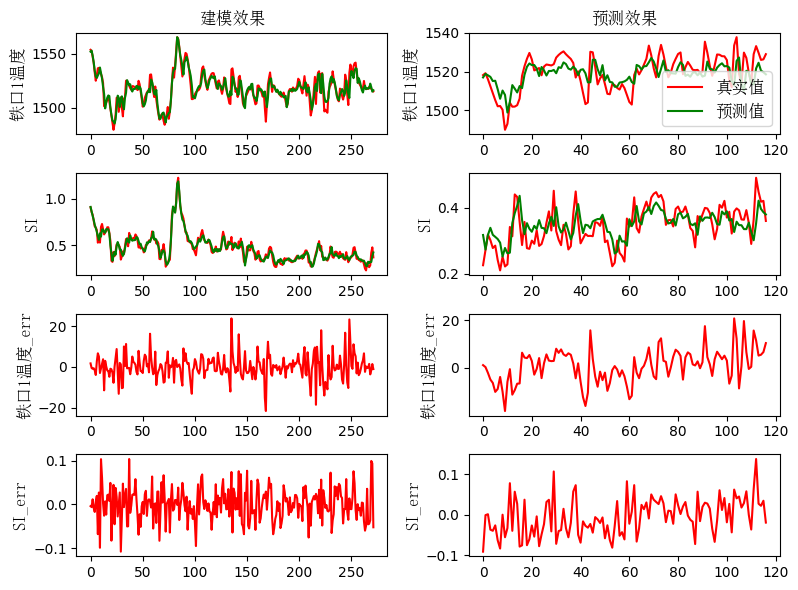

In [97]:
# 高炉模型预测
y_train_pred_0,y_train_pred_1 = REFLNS_model_gaolu.my_predict(X_gaolu_train)
y_test_pred_0,y_test_pred_1 = REFLNS_model_gaolu.my_predict(X_gaolu_test)

base.double_control_train_test_result(scalers,  output_term,
                                        y_gaolu_train,  y_train_pred_0, y_train_pred_1,
                                        y_gaolu_test,   y_test_pred_0,  y_test_pred_1)



In [98]:
# 创建模
params =   [1 , 1, 0 ,0.1] 
REFLNS_model_predict = My_M_LS_REFLNS(params=params,
                                features_size=X_gaolu_train.shape[1], 
                                ae_hidden_size=256,
                                lam_l2 = lam_l2)
# 训练模型
REFLNS_model_predict.fit(X_gaolu_test, y_gaolu_test)


(117, 16)
(117, 117)
(117, 256)
(117, 16)
(117, 272)


训练集
RMSE:  铁口1温度: 5.2389 , SI: 0.0369 
MAPE:  铁口1温度: 0.2709% , SI: 8.8294%
MRE :  铁口1温度: 0.0027  , SI: 0.0883 
per :  铁口1温度: 0.9402  , SI: 0.9915 
测试集
RMSE:  铁口1温度: 12.7345 , SI: 0.2333 
MAPE:  铁口1温度: 0.6199% , SI: 35.5391%
MRE :  铁口1温度: 0.0062  , SI: 0.3554 
per :  铁口1温度: 0.6397  , SI: 0.5037 


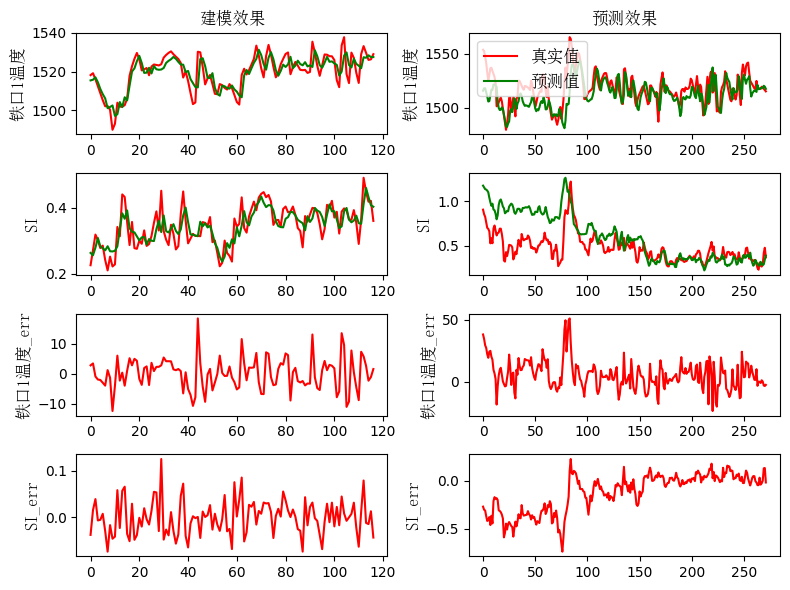

In [99]:
# 预测建模效果
y_train_pred_0,y_train_pred_1 = REFLNS_model_predict.my_predict(X_gaolu_test)

y_test_pred_0,y_test_pred_1 = REFLNS_model_predict.my_predict(X_gaolu_train)


base.double_control_train_test_result(scalers,  output_term,
                                        y_gaolu_test,  y_train_pred_0, y_train_pred_1,
                                        y_gaolu_train,   y_test_pred_0,  y_test_pred_1)


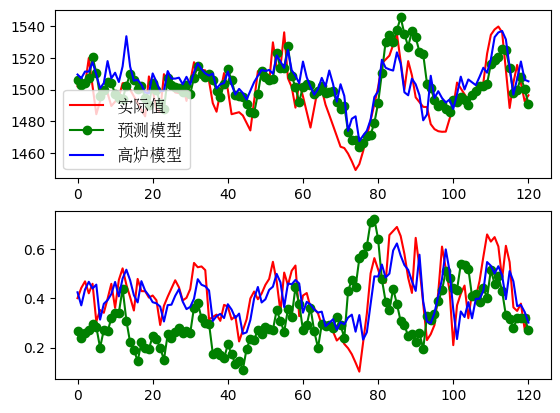

In [100]:
base.gaolu_predict_raw(scalers,output_term,REFLNS_model_predict,REFLNS_model_gaolu,X_predict_test,y_predict_test)


In [101]:
# 生成期望数据
Times = 100

def generate_y_aim_data(Times):

    set_y1 = np.full(Times,1500)
    set_y1[30:] = 1510
    set_y1[60:] = 1505
    set_y1[90:] = 1515
    # set_y1[70:] = 1520
    # set_y1[90:] = 1525

    set_y2 = np.full(Times,0.44)
    set_y2[15:] = 0.48
    set_y2[45:] = 0.52
    set_y2[75:] = 0.44
    # 限制设定值在 -1 到 1 之间
    # set_y1 = np.clip(set_y1, -1, 1)
    # set_y2 = np.clip(set_y2, -1, 1)


    set_y1_trans = scalers[output_term[0]].transform(set_y1.reshape(-1,1)).flatten()
    set_y2_trans = scalers[output_term[1]].transform(set_y2.reshape(-1,1)).flatten()

    return set_y1, set_y2, set_y1_trans, set_y2_trans

# # 调用示例
# set_y1, set_y2, set_y1_trans, set_y2_trans= generate_y_aim_data(Times)
# plt.plot(set_y1_trans)
# plt.plot(set_y2_trans)
# plt.title('y_sp')
# plt.show()



In [102]:
# 生成参考轨迹
def get_yr(aim_value,current_value,alpha,P):
    # 生成设定信号
    setpoint_signal = np.full(10, aim_value)
    # 初始化参数
    alpha = alpha
    y_r = np.zeros(P)
    y_r[0] = current_value
    # 模拟一阶模型
    for k in range(1,P):
        y_r[k] = alpha * y_r[k-1] + (1 - alpha) * aim_value

    # # 绘制结果
    # plt.plot(setpoint_signal, label='Setpoint Signal')
    # plt.plot(y_r,'o-', label='Output Signal (Tracked)')
    # plt.legend()
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')
    # plt.title('Tracking Setpoint Signal with One-Order Model')
    # plt.show()
    return y_r
# 测试
y_r = get_yr(1,-0.5,0.667,5+1)


In [103]:
#生成控制时域的数据格式
def generate_k_data(u1_data, u2_data, u3_data, u4_data, u5_data, u6_data, u7_data, y1_data,y2_data, num_samples, P):
    nearest_index = np.abs(y1_data - (-0.5)).argmin()
    # 生成随机索引值
    #从原有数据的randint时刻开始往下进行控制
    randint = np.random.randint(1, num_samples - 2 - P - 1)
    randint = nearest_index  # 如果你希望使用固定的值而不是随机生成
    # randint = 250  # 如果你希望使用固定的值而不是随机生成
    print(randint)
    # 提取数据并构成 k_data
    # 第一次得到下面五个变量，固定好格式构成k_data
    u1   = u1_data[randint  :randint+3  ]
    u2   = u2_data[randint  :randint+3  ]
    u3   = u3_data[randint  :randint+3  ]
    u4   = u4_data[randint  :randint+3  ]
    u5   = u2_data[randint  :randint+3  ]
    u6   = u3_data[randint  :randint+3  ]
    u7   = u4_data[randint  :randint+3  ]

    y1   = y1_data[randint  :randint+3  ]
    y2   = y2_data[randint  :randint+3  ]
    k_data = np.concatenate((u1, u2, u3, u4, u5, u6, u7, y1, y2), axis=0)
    print(k_data.shape)

    k_data = np.zeros_like(k_data)
    return k_data



In [104]:
# 定义单时刻的MPC问题优化
def my_MPC(k_data,params,M,P,y1_aim,y2_aim,isprint):
    h1 = 0.0
    h2 = 0.0
    lamda1 = 0.001
    lamda2 = 0.001
    lamda3 = 0.001
    lamda4 = 0.001
    y1_percent = 1.0
    y2_percent = 1.0

    # 从固定格式k_data里面读取信息
    u1   = k_data[0:3]
    u2   = k_data[3:6]
    u3   = k_data[6:9]
    u4   = k_data[9:12]
    u5   = k_data[12:15]
    u6   = k_data[15:18]
    u7   = k_data[18:21]

    y1   = k_data[21:24]
    y2   = k_data[24:27]

    
    # 获取猜测值[h U1 U2]
    # h, U1, U2  =params[0], params[1:M+1],params[M+1:]
    U1, U2, U3, U4, U5, U6, U7  =params[0:M], params[M:2*M],params[2*M:3*M], params[3*M:4*M], params[4*M:5*M],params[5*M:6*M], params[6*M:7*M]
    
    # 整理数据见   MPC推到.escel
    u1   = np.concatenate((u1,U1,U1[-1]*np.ones(P-M)))
    u2   = np.concatenate((u2,U2,U2[-1]*np.ones(P-M)))
    u3   = np.concatenate((u3,U3,U3[-1]*np.ones(P-M)))
    u4   = np.concatenate((u4,U4,U4[-1]*np.ones(P-M)))
    u5   = np.concatenate((u5,U5,U5[-1]*np.ones(P-M)))
    u6   = np.concatenate((u6,U6,U6[-1]*np.ones(P-M)))
    u7   = np.concatenate((u7,U7,U7[-1]*np.ones(P-M)))
    y1   = np.concatenate((y1,np.zeros(P)))
    y2   = np.concatenate((y2,np.zeros(P)))
    if isprint:
        print(u1.round(4))
        print(u2.round(4))
        print(u3.round(4))
        print(u4.round(4))
        print(u5.round(4))
        print(u6.round(4))
        print(u7.round(4))
        print(y1.round(4))    
        print(y2.round(4))
        print('开始预测')

    y1_k = y1[2]
    y2_k = y2[2]





    # 总共预测 P+1 次
    # 对k时刻进行预测-----1次
    for j in range(1):   # j = 0
        x = np.column_stack((   u1[j+2],u2[j+2],u3[j+2],u4[j+2],
                                u5[j+2],u6[j+2],u7[j+2],
                                u1[j+1],u2[j+1],u3[j+1],u4[j+1],
                                u5[j+1],u6[j+1],u7[j+1],
                                y1[j+1],y2[j+1]))
        # x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_m_k, y2_m_k = REFLNS_model_predict.my_predict(x)
        E1_k = y1_k - y1_m_k
        E2_k = y2_k - y2_m_k
        if isprint:
            print(j,'mode = 0')
            print(x.round(4))
            print(y1_k.round(4),y2_k.round(4))
            print(y1_m_k.round(4),y2_m_k.round(4))

    # 对控制时刻进行预测-----M次
    for j in range(1,M+1):  # j = 1,2
        x = np.column_stack((   u1[j+2],u2[j+2],u3[j+2],u4[j+2],
                                u5[j+2],u6[j+2],u7[j+2],
                                u1[j+1],u2[j+1],u3[j+1],u4[j+1],
                                u5[j+1],u6[j+1],u7[j+1],
                                y1[j+1],y2[j+1]))
        # x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_k_j, y2_k_j = REFLNS_model_predict.my_predict(x)
        y1[j+2] = y1_k_j.item()
        y2[j+2] = y2_k_j.item()
        if isprint:
            print(j,'mode = 1')
            print(x.round(4))
            print(y1_k_j.round(4),y2_k_j.round(4))
            print('更新后:')
            print(u1.round(4))
            print(u2.round(4))
            print(u3.round(4))
            print(u4.round(4))
            print(u5.round(4))
            print(u6.round(4))
            print(u7.round(4))
            print(y1.round(4))    
            print(y2.round(4))

    # 对控制时域外的部分进行预测-----P-M次
    # 注意：这部分的信号是保持控制不变下进行
    for j in range(M+1,P+1):  #j = 3,4
        x = np.column_stack((   u1[j+2],u2[j+2],u3[j+2],u4[j+2],
                                u5[j+2],u6[j+2],u7[j+2],
                                u1[j+1],u2[j+1],u3[j+1],u4[j+1],
                                u5[j+1],u6[j+1],u7[j+1],
                                y1[j+1],y2[j+1]))
        # x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_k_j, y2_k_j = REFLNS_model_predict.my_predict(x)
        y1[j+2] = y1_k_j.item()#将预测值作为下一步的输出值
        y2[j+2] = y2_k_j.item()
        if isprint:
            print(j,'mode = 2')
            print(x.round(4))
            print(y1_k_j.round(4),y2_k_j.round(4))
            print('更新后:')
            print(u1.round(4))
            print(u2.round(4))
            print(u3.round(4))
            print(u4.round(4))
            # print(u5.round(4))
            # print(u6.round(4))
            # print(u7.round(4))
            print(y1.round(4))    
            print(y2.round(4))



    # k_data2 = np.concatenate((u1[1:4],u2[1:4],u3[1:4],u4[1:4],y1[1:4],y2[1:4]),axis=0)  
    k_data2 = np.concatenate((u1[1:4],u2[1:4],u3[1:4],u4[1:4],u5[1:4],u6[1:4],u7[1:4],y1[1:4],y2[1:4]),axis=0)


    if isprint:
        print('更新k_data')
        print(k_data2.round(4))


    #获取参考轨迹
    # 一定要对照好做差的序列
    y1_r_aim  = get_yr(y1_aim,y1_k,0.1,P+1)
    y1_r = y1_r_aim[1:] 


    y2_r_aim  = get_yr(y2_aim,y2_k,0.1,P+1)
    y2_r = y2_r_aim[1:] 

    y1_M_k = y1[3:]
    y2_M_k = y2[3:]
    if isprint==1:
        print('反馈补偿:')
        print('y1_k',y1_k.round(4))  
        print('y1_m_k',y1_m_k.round(4))    
        print('h*E1_k',(h1*E1_k).round(4)) 
        print('y2_k',y2_k.round(4))  
        print('y2_m_k',y2_m_k.round(4))   
        print('h*E2_k',(h2*E2_k).round(4))

        print('temp:')
        print('y1_aim',y1_aim.round(4))
        print('y1_r_aim',y1_r_aim.round(4))
        print('y1_r',y1_r.round(4))
        print('y1_M_k',y1_M_k.round(4))
        print('y1_M_k+h1*E1_k',(y1_M_k+h1*E1_k).round(4))

        print('Si_percent:')
        print('y2_aim',y2_aim.round(4))
        print('y2_r_aim',y2_r_aim.round(4))
        print('y2_r',y2_r.round(4))
        print('y2_M_k',y2_M_k.round(4))
        print('y2_M_k+h2*E2_k',(y2_M_k+h2*E2_k).round(4))

        print('u:')
        print(u1[2:].round(4))
        print(u2[2:].round(4))
        print(u3[2:].round(4))
        print(u4[2:].round(4))
        
    # 计算mse
    # lamda1太大的话会导致y1_r和y1_M_k的误差加大*****************导致超调的原因\与目标值之间存在间隙


    y1_err = y1_percent*np.sum((y1_r-(y1_M_k+h1*E1_k))**2) 
    y2_err = y2_percent*np.sum((y2_r-(y2_M_k+h2*E2_k))**2) 
    u1_power = lamda1*np.sum((np.diff(u1[2:]))**2)
    u2_power = lamda2*np.sum((np.diff(u2[2:]))**2)
    u3_power = lamda3*np.sum((np.diff(u3[2:]))**2)
    u4_power = lamda4*np.sum((np.diff(u4[2:]))**2)
    u5_power = lamda2*np.sum((np.diff(u5[2:]))**2)
    u6_power = lamda3*np.sum((np.diff(u6[2:]))**2)
    u7_power = lamda4*np.sum((np.diff(u7[2:]))**2)

    # y1_err = y1_percent*np.sum(np.fabs(y1_r-(y1_M_k+h1*E1_k))) 
    # y2_err = y2_percent*np.sum(np.fabs(y2_r-(y2_M_k+h2*E2_k))) 
    # u1_power = lamda1*np.sum((np.fabs(np.diff(u1))))
    # u2_power = lamda2*np.sum((np.fabs(np.diff(u2))))
    # u3_power = lamda3*np.sum((np.fabs(np.diff(u3))))
    # u4_power = lamda4*np.sum((np.fabs(np.diff(u4))))
    # u5_power = lamda2*np.sum((np.fabs(np.diff(u5))))
    # u6_power = lamda3*np.sum((np.fabs(np.diff(u6))))
    # u7_power = lamda4*np.sum((np.fabs(np.diff(u7))))

    mse = (0
            +y1_err
            +y2_err
            +u1_power
            +u2_power
            +u3_power
            +u4_power
            +u5_power
            +u6_power
            +u7_power
            )
    
    # print('mse {:.7f}'.format(mse))
    if isprint==1:
        print('mse {:.7f}'.format(mse))
        print('1111 {:.7f}'.format(y1_err))
        print('2222 {:.7f}'.format(y2_err))
        print('1111 {:.7f}'.format(u1_power))
        print('2222 {:.7f}'.format(u2_power))
        print('3333 {:.7f}'.format(u3_power))
        print('4444 {:.7f}'.format(u4_power))



    return mse , k_data2, E1_k*h1,  E2_k*h2
    # return mse , k_data2, E1_k*h1


In [105]:
Times = 200
iscontrol = True
iscontrol = False
if_gaolu_is_predict = 0


In [106]:
# 对未来Times周期预测控制
max_control = 1.0
# 期望设定值
set_y1, set_y2, set_y1_trans, set_y2_trans = generate_y_aim_data(Times)

# MPC参数
P = 4  # 预测时域长度  增大P能平稳些
M = 2  # 控制时域长度
#生成控制时域的数据格式
k_data = generate_k_data(u1_data, u2_data, u3_data, u4_data,
                        u5_data, u6_data, u7_data, 
                        y1_data, y2_data, num_samples, P)


# MPC控制循环   迭代的只有：k_data
all_pred_y1 = []
all_pred_y2 = []
all_pred_u1 = []
all_pred_u2 = []
all_pred_u3 = []
all_pred_u4 = []
all_pred_u5 = []
all_pred_u6 = []
all_pred_u7 = []
# MPC控制循环40
for k in range(Times):
    if iscontrol == False:
        break

    print(f"这是对第{k}时刻的最优U1、U2输入求解")

    # 定义优化目标函数
    def objective_function(params, *k_data):
        mse, k_data2, E1_k_0, E2_k_0 = my_MPC(k_data=k_data[0], params=params, 
                                M=M, P=P, 
                                y1_aim = set_y1_trans[k], y2_aim = set_y2_trans[k],
                                isprint = 0) 
        return mse
    
    # 初始猜测值[h U1 U2]   定义参数的上下限    设置退出条件
    params = np.concatenate([np.ones(M), np.ones(M),np.ones(M), np.ones(M), np.ones(M),np.ones(M), np.ones(M)])
    # params = np.concatenate([np.ones(M), np.ones(M),np.ones(M), np.ones(M)])
    bounds = [(-max_control, max_control) for _ in range(7 * M)]
    exit_conditions = {'maxiter': 1000} 
    # 进行优化
    result = minimize(objective_function, params, method='L-BFGS-B', 
                    bounds=bounds, args=k_data)#args传进来的是一个元组


    U1, U2, U3, U4, U5, U6, U7 =    result.x[0:M], result.x[M:2*M], \
                                    result.x[2*M:3*M], result.x[3*M:4*M], \
                                    result.x[4*M:5*M], result.x[5*M:6*M], \
                                    result.x[6*M:7*M]
    

    u1   = k_data[0:3]
    u2   = k_data[3:6]
    u3   = k_data[6:9]
    u4   = k_data[9:12]
    u5   = k_data[12:15]
    u6   = k_data[15:18]
    u7   = k_data[18:21]

    y1   = k_data[21:24]
    y2   = k_data[24:27]
    u1   = np.concatenate((u1,U1,U1[-1]*np.ones(P-M)))
    u2   = np.concatenate((u2,U2,U2[-1]*np.ones(P-M)))
    u3   = np.concatenate((u3,U3,U3[-1]*np.ones(P-M)))
    u4   = np.concatenate((u4,U4,U4[-1]*np.ones(P-M)))
    u5   = np.concatenate((u5,U5,U5[-1]*np.ones(P-M)))
    u6   = np.concatenate((u6,U6,U6[-1]*np.ones(P-M)))
    u7   = np.concatenate((u7,U7,U7[-1]*np.ones(P-M)))
    y1   = np.concatenate((y1,np.zeros(P)))
    y2   = np.concatenate((y2,np.zeros(P)))



    # 将控制序列第一个数作用于高炉
    j = 1
    x = np.column_stack((   u1[j+2],u2[j+2],u3[j+2],u4[j+2],u5[j+2],u6[j+2],u7[j+2],
                            u1[j+1],u2[j+1],u3[j+1],u4[j+1],u5[j+1],u6[j+1],u7[j+1],
                            y1[j+1],y2[j+1]))
    # x = x.reshape((x.shape[0], 1, x.shape[1]))
    y1_pred0, y2_pred0 = REFLNS_model_predict.my_predict(x)
    if if_gaolu_is_predict:
        y1_pred, y2_pred = REFLNS_model_predict.my_predict(x)
    else:
        y1_pred, y2_pred = REFLNS_model_gaolu.my_predict(x)
    


    # 更新k_data
    params = np.concatenate((U1, U2, U3, U4, U5, U6, U7),axis=0)
    mse, k_data2, E1_k_0, E2_k_0 =my_MPC(k_data=k_data,params=params,
                            M=M,P=P, 
                            y1_aim = set_y1_trans[k], y2_aim = set_y2_trans[k],
                            isprint = 0) 


    print(  '1设定',set_y1_trans[k].round(4),\
            '预测',y1_pred0.round(4),\
            '高炉', y1_pred.round(4),\
            '高炉与设定误差',(set_y1_trans[k]-y1_pred).round(4),(set_y1_trans[k]-y1_pred).round(4)/d_temp,\
            '模型误差',(y1_pred0 - y1_pred).round(4),\
            '校正值',E1_k_0.round(4))
    print(  '2设定',set_y2_trans[k].round(4),\
            '预测',y2_pred0.round(4),\
            '高炉', y2_pred.round(4),\
            '高炉与设定误差',(set_y2_trans[k]-y2_pred).round(4),(set_y2_trans[k]-y2_pred).round(4)/d_yuansu,\
            '模型误差',(y2_pred0 - y2_pred).round(4),\
            '校正值',E2_k_0.round(4))




    all_pred_y1.append(y1_pred)
    all_pred_y2.append(y2_pred)
    all_pred_u1.append(U1[0])
    all_pred_u2.append(U2[0])
    all_pred_u3.append(U3[0])
    all_pred_u4.append(U4[0])
    all_pred_u5.append(U5[0])
    all_pred_u6.append(U6[0])
    all_pred_u7.append(U7[0])
    k_data2[23] = y1_pred.item()
    k_data2[26] = y2_pred.item()
    k_data = k_data2
    # 进入下一时刻，更新预测时域、控制时域，即k_data


2838
(27,)


In [107]:
if iscontrol:
    y1_pred_inverse_transform = scalers[output_term[0]].inverse_transform(np.array(all_pred_y1).reshape(-1, 1)).flatten()
    y2_pred_inverse_transform = scalers[output_term[1]].inverse_transform(np.array(all_pred_y2).reshape(-1, 1)).flatten()
    
    plt.subplot(2, 1, 1)
    plt.plot(y1_pred_inverse_transform[5:],'b', label='实际值')
    plt.plot(set_y1[5:],'r', label='设定值')
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.grid(linestyle='--', alpha=0.7, color='gray')
    plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签
    plt.legend(prop=font)
    plt.title("REFLNS模型预测控制效果", fontproperties=font)

    plt.subplot(2, 1, 2)
    plt.plot(y2_pred_inverse_transform[5:],'b')
    plt.plot(set_y2[5:],'r')
    plt.ylabel(output_term[1], fontproperties=font)  # 使用中文标签
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.grid(linestyle='--', alpha=0.7, color='gray')


# if iscontrol:
#     y1_pred_inverse_transform = scalers[output_term[0]].inverse_transform(np.array(all_pred_y1).reshape(-1, 1)).flatten()
#     y2_pred_inverse_transform = scalers[output_term[1]].inverse_transform(np.array(all_pred_y2).reshape(-1, 1)).flatten()
#     y1_pred_noise_inverse_transform = scalers[output_term[0]].inverse_transform(np.array(all_pred_y1).reshape(-1, 1)-np.array(gaussian_noise_TEMP).reshape(-1, 1)).flatten()
#     y2_pred_noise_inverse_transform = scalers[output_term[1]].inverse_transform(np.array(all_pred_y2).reshape(-1, 1)-np.array(gaussian_noise_SI).reshape(-1, 1)).flatten()
#     plt.subplot(2, 1, 1)
#     plt.plot(y1_pred_inverse_transform[5:],'b')
#     plt.plot(set_y1[5:],'r')
#     if if_add_noise:
#         plt.plot(y1_pred_noise_inverse_transform[5:],'g')
    
#     plt.grid(linestyle='--', alpha=0.7, color='gray')
#     plt.subplot(2, 1, 2)
#     plt.plot(y2_pred_inverse_transform[5:],'b')
#     plt.plot(set_y2[5:],'r')
#     if if_add_noise:
#         plt.plot(y2_pred_noise_inverse_transform[5:],'g')
    
#     plt.grid(linestyle='--', alpha=0.7, color='gray')


In [108]:
# 数据转换、
if iscontrol:
    base.data_tranform_plot_7_2(scalers,Times ,max_control,
                        output_term,input_term,
                        set_y1,set_y2,set_y1_trans,set_y2_trans,
                        all_pred_y1, all_pred_y2,
                        all_pred_u1,
                        all_pred_u2,
                        all_pred_u3,
                        all_pred_u4,
                        all_pred_u5,
                        all_pred_u6,
                        all_pred_u7)
